In [3]:
import pandas as pd
import numpy as np
from nltk.tokenize import MWETokenizer
import re
import nltk

import matplotlib.pyplot as plt

def explode_list(df, col):
    s = df[col]
    i = np.arange(len(s)).repeat(s.str.len())
    return df.iloc[i].assign(**{col: np.concatenate(s)})


def tokenize(text):
    a = re.sub(r'[^\w\s]','', text)
    a = mwe.tokenize(a.lower().split())
    tokens_with_keywords = [word for word in a if word in keyword['mwe'].tolist()]
    return tokens_with_keywords

#get the keyword, put it in the dataframe with keyword, mwe (Multi-Word Expression Tokenizer ntlk)
url = 'https://raw.githubusercontent.com/zahradaniar/summer2021internship/master/City%20Of%20Boston/portugese_keywords.csv'
keyword = pd.read_csv(url, header=None)
keyword.columns = ['keyword']
keyword['mwe'] = keyword['keyword'].str.replace(' ','_')
keyword['mwe'] = keyword['mwe'].str.lower()

#build the MWE tokenizer
mwe = MWETokenizer()
for index, row in keyword.iterrows():
    mwe.add_mwe(row['keyword'].split())

#get the articles
url = 'https://raw.githubusercontent.com/BU-Spark/summer2021internship/master/City%20Of%20Boston/data/BrazilianTimes_Jan2020_to_Jun2021.csv'
df = pd.read_csv(url, index_col=[0])

#combine the Title and Article
df["Article"] = df["Title"] + df["Article"]
df['tokenized_text'] = df.apply(lambda row: tokenize(row['Article']) , axis=1)

#now we done with Article, drop everything but tokenized text
df= df.drop(['URL', 'Title', 'Article'], axis = 1)
df = explode_list(df, 'tokenized_text')

#replace index from the Date into real index
df.reset_index(inplace=True)

#change the Date column from string type to DateTime
df['Date'] =  pd.to_datetime(df['Date'], format='%Y-%M-%d')

#put the week and the year 
df['Year/Week'] = df['Date'].apply(lambda x: "%d-%d" % (x.year, x.week))
pd.set_option('display.max_rows', df.shape[0]+1)
df.groupby(['Year/Week', 'tokenized_text']).size()


Year/Week  tokenized_text           
2020-1     acampamento                    1
           autorização_de_trabalho        1
           beleza                        42
           cobertura_facial               1
           compras                        8
           coronavírus                  171
           cosméticos                     5
           covid                          3
           covid19                      150
           covid_19                       2
           desinfetante                   1
           diarreia                       1
           distanciamento_social          9
           dor_de_cabeça                  3
           dor_de_garganta                1
           elevador                       6
           fadiga                         1
           falta_de_ar                    2
           febre                          9
           férias                        10
           hotel                         18
           moderna                     

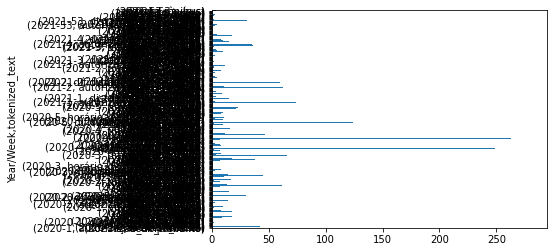

In [17]:
df.groupby(['Year/Week', 'tokenized_text']).size().plot(kind='barh')   #--JohnE
# Add xticks on the middle of the group bars
plt.show()